# Курсовая работа
## Семантическая сегментация изображений

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F

import cv2
import albumentations as A

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Загрузка данных

Будем использовать датасет DroneDataset  
http://dronedataset.icg.tugraz.at

In [3]:
img_data_path = '/content/drive/MyDrive/mai_cv_mag/dataset/dataset/semantic_drone_dataset/original_images/'
masks_data_path = '/content/drive/MyDrive/mai_cv_mag/dataset/dataset/semantic_drone_dataset/label_images_semantic/'


Сделаем датасет с айдишниками и поделим его на трейн/тест/вал

In [4]:
name = []
for _, _, filenames in os.walk(img_data_path):
    for filename in filenames:
        name.append(filename.split('.')[0])

img_data = pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

In [5]:
len(img_data)

400

Поделим данные на трейн/тест/вал

Трейн - 72%  
Тест - 18%  
Вал - 10%

In [6]:
from sklearn.model_selection import train_test_split


X_traintest, X_val = train_test_split(img_data['id'].values, test_size=0.1)
X_train, X_test = train_test_split(X_traintest, test_size=0.2)

In [7]:
len(X_train), len(X_test), len(X_val)

(288, 72, 40)

Пример картинки и маски

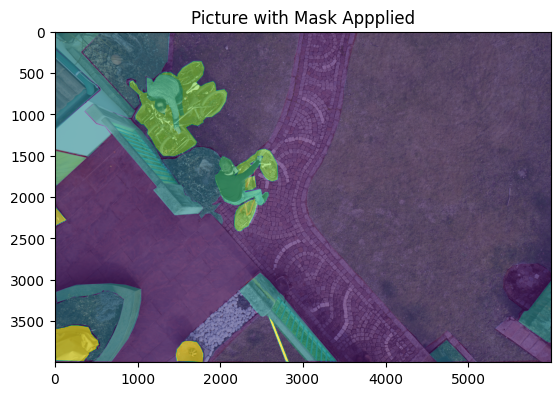

In [8]:
img = Image.open(img_data_path + img_data['id'][2] + '.jpg')
mask = Image.open(masks_data_path + img_data['id'][2] + '.png')

plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [9]:
np.asarray(img).shape, np.asarray(mask).shape

((4000, 6000, 3), (4000, 6000))

Класс для работы с датасетом

In [84]:
class SegDataset(Dataset):
    def __init__(self, img_path, mask_path, df, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.df = df
        self.transform = transform
        self.mean = (0.485, 0.456, 0.406)
        self.std = (0.229, 0.224, 0.225)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.df[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.df[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)

        mask = torch.from_numpy(mask).long()

        return img, mask


Создаем датасеты. Для трейна добавим аугментации, в тесте (и в вале) будем только ресайзить

In [21]:
t_train = A.Compose(
    [
        A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.GridDistortion(p=0.2),
        A.RandomBrightnessContrast((0,0.5),(0,0.5)),
        A.GaussNoise(),
     ]
)

t_test = A.Compose(
    [
        A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
    ]
)

train_dataset = SegDataset(img_data_path, masks_data_path, X_train, t_train)
test_dataset = SegDataset(img_data_path, masks_data_path, X_test, t_test)

Создаем даталоадеры

In [22]:
batch_size = 3

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Создаем модель. Будем использовать библиотеку segmentation_models_pytorch, которая позволяет довольно просто и быстро сконструировать желаемую архитектуру модели

In [13]:
!pip install -q segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.4 MB/s eta 0:00:00


In [14]:
import segmentation_models_pytorch as smp

Будем использовать mobilenet с архитектурой Encoder-Decoder

In [15]:
model = smp.Unet(
    'mobilenet_v2', encoder_weights='imagenet', classes=23,
    activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16]
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 45.3MB/s]


### Обучение

Вычисление попиксельного accuracy

In [16]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

Вычисление метрики mIoU

In [17]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for cl in range(0, n_classes):
            true_class = (pred_mask == cl)
            true_label = (mask == cl)

            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)


Пайплайн обучения и валидации модели

In [23]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit(epochs, model, train_loader, test_loader, criterion, optimizer, scheduler, patch=False):
    train_losses = []
    test_losses = []
    val_iou = []
    val_acc = []
    train_iou = []
    train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1
    not_improve = 0

    model.to(device)

    for e in range(epochs):
        running_loss = 0
        iou_score = 0
        accuracy = 0
        model.train()

        for i, data in enumerate(tqdm(train_loader)):
            image_tiles, mask_tiles = data

            image = image_tiles.to(device)
            mask = mask_tiles.to(device)

            output = model(image)
            loss = criterion(output, mask)

            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            scheduler.step()
            running_loss += loss.item()


        model.eval()
        test_loss = 0
        test_accuracy = 0
        val_iou_score = 0

        with torch.no_grad():
            for i, data in enumerate(tqdm(test_loader)):
                image_tiles, mask_tiles = data

                image = image_tiles.to(device)
                mask = mask_tiles.to(device)

                output = model(image)

                val_iou_score +=  mIoU(output, mask)
                test_accuracy += pixel_accuracy(output, mask)

                loss = criterion(output, mask)
                test_loss += loss.item()


            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))

            val_iou.append(val_iou_score/len(test_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(test_loader))

    history = {
        'train_loss' : train_losses, 'val_loss' : test_losses,
        'train_miou' : train_iou, 'val_miou' : val_iou,
        'train_acc' : train_acc, 'val_acc' : val_acc, 'lrs' : lrs,
        }

    return history

Обучаем модель и сохраняем статистики обучения

In [24]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr, epochs=epoch, steps_per_epoch=len(train_loader)
)

history = fit(epoch, model, train_loader, test_loader, criterion, optimizer, sched)

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [26]:
torch.save(model, 'mobilenet.pt')

Результаты обучения

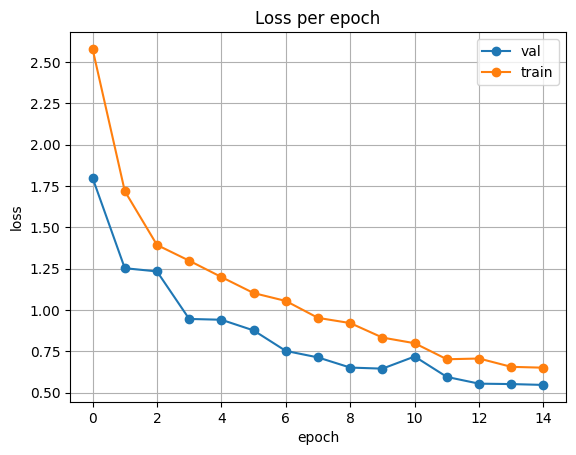

In [27]:
plt.plot(history['val_loss'], label='val', marker='o')
plt.plot(history['train_loss'], label='train', marker='o')
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

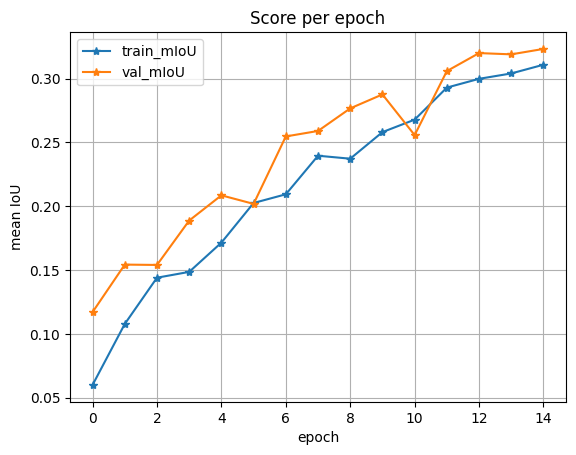

In [28]:
plt.plot(history['train_miou'], label='train_mIoU', marker='*')
plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
plt.title('Score per epoch'); plt.ylabel('mean IoU')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

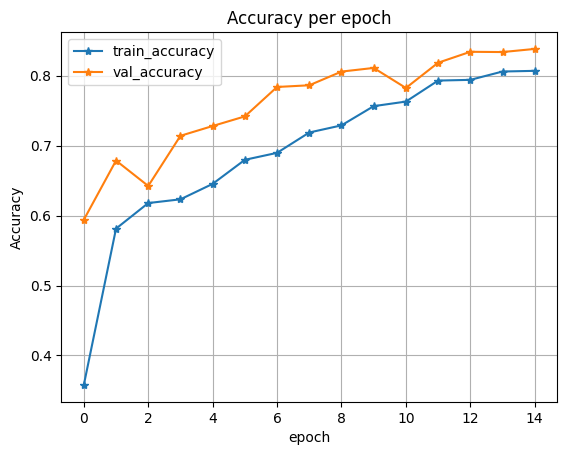

In [29]:
plt.plot(history['train_acc'], label='train_accuracy', marker='*')
plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

Модель научилась сегментировать изображения. Значение mIoU на тестовой выборке =

### Валидация

In [92]:
val_dataset = SegDataset(img_data_path, masks_data_path, X_val, t_test)

Функция для процессинга одного изобрежния (получить предикт и посчитать скор)

In [93]:
def process_single_image(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    # t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    # image = t(image)
    model.to(device)
    image = image.to(device)
    mask = mask.to(device)

    with torch.no_grad():
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

Посчитать скоры для всей валидационной выборки

In [94]:
def calc_iou_score(model, val_dataset):
    score_iou = []
    for i in tqdm(range(len(val_dataset))):
        img, mask = val_dataset[i]
        pred_mask, score = process_single_image(model, img, mask)
        score_iou.append(score)
    return np.array(score_iou).mean()

In [54]:
calc_iou_score(model, val_dataset)

  0%|          | 0/40 [00:00<?, ?it/s]

0.3665787361081629

Значение mIoU на валидационной части выборки = 0.3665